# Generate simulated PMT pulse

David Cussans , December 2025

First import the libraries we need

In [1]:
import numpy as np
import scipy
import skrf
import matplotlib.pyplot as plt

Define routine that produces a power spectral density by interpolating from an array of values

In [2]:
def interpolate_psd(freqs_data, psd_data, n_samples, fs):
    """
    Interpolate measured PSD data onto FFT frequency grid.
    
    Parameters:
    -----------
    freqs_data : ndarray
        Frequencies of the measured PSD (Hz).
    psd_data : ndarray
        PSD values at freqs_data.
    n_samples : int
        Number of time samples.
    fs : float
        Sampling frequency (Hz).
    
    Returns:
    --------
    freqs_fft : ndarray
        FFT frequency bins.
    psd_interp : ndarray
        PSD values interpolated onto FFT bins.
    """
    freqs_fft = scipy.fft.rfftfreq(n_samples, 1/fs)
    psd_interp = np.interp(freqs_fft, freqs_data, psd_data, left=0, right=0)
    return freqs_fft, psd_interp

Given a PSD generate a time series of the noise

In [3]:
def noise_from_psd_array(psd_vals, n_samples=1024, fs=1.0):
    """
    Generate a noise time series with a given power spectral density (PSD array).
    """
    
    # Return the Discrete Fourier Transform sample frequencies (for usage with rfft, irfft).
    # d = Sample spacing (inverse of the sampling rate)
    freqs = scipy.fft.rfftfreq(n = n_samples, d = 1/fs)
    assert len(psd_vals) == len(freqs), "PSD array length mismatch"

    # Random phases
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs)))

    # Amplitudes scaled by PSD
    amplitudes = np.sqrt(psd_vals * fs * n_samples / 2.0) * random_phases

    # Build Hermitian-symmetric full spectrum
    spectrum = np.zeros(n_samples, dtype=complex)
    spectrum[:len(amplitudes)] = amplitudes
    spectrum[-(len(amplitudes)-1):] = np.conj(amplitudes[1:][::-1])

    # Inverse FFT
    x = scipy.fft.ifft(spectrum).real
    t = np.arange(n_samples) / fs

    # Verify PSD
    Xf = scipy.fft.rfft(x)
    psd_est = (np.abs(Xf) ** 2) / (fs * n_samples)

    return t, x, freqs, psd_est

Function to return white noise

In [41]:
def white_noise_array(n_samples=1024, fs=1.0):
    """
    Generate a noise time series with a flat time distribution (white noise)
    """
    
    # Return the Discrete Fourier Transform sample frequencies (for usage with rfft, irfft).
    # d = Sample spacing (inverse of the sampling rate)
    freqs = scipy.fft.rfftfreq(n = n_samples, d = 1/fs)
    #assert len(psd_vals) == len(freqs), "PSD array length mismatch"

    # Random phases
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs)))

    # Amplitudes- flat PSD
    psd_vals = np.array(len(freqs)*[1.0])
    print(psd_vals)
    #amplitudes = np.sqrt( fs * n_samples / 2.0) * random_phases
    amplitudes = 1.0 * random_phases

    # Build Hermitian-symmetric full spectrum
    spectrum = np.zeros(n_samples, dtype=complex)
    spectrum[:len(amplitudes)] = amplitudes
    spectrum[-(len(amplitudes)-1):] = np.conj(amplitudes[1:][::-1])

    # Inverse FFT
    x = scipy.fft.ifft(spectrum).real
    #t = np.arange(n_samples) / fs
    t = np.linspace( start = -0.5*n_samples/fs, stop = 0.5*n_samples/fs , num=n_samples )

    # Verify PSD
    Xf = scipy.fft.rfft(x)
    psd_est = (np.abs(Xf) ** 2) / (fs * n_samples)

    return t, x, freqs, psd_est

In [42]:
def gaussian_func(x, mu, sig):
    # normalization = 1.0 / (np.sqrt(2.0 * np.pi) * sig)  
    normalization = 1.0
    y = normalization * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    return ( y)

In [43]:
def gaussian_time_domain(n_samples=1024, fs=1.0 , centre_pos = 0.5 , time_width=10.0 , peak_height=1.0):
    """
    Generate a time series of a Gaussian

    Parameters:
    -----------
    n_samples : int
        Number of time samples.
    fs : float
        Sampling frequency (Hz).
    centre_pos : float
        Centre of the Gaussian in the samples
    time_width : float
        Width(sigma) of the Gaussian in units of seconds ( i.e. 1/fs )
    peak_height : float

    Returns:
    --------

    time_values : ndarray
        Time value of each sample

    amplitude_values : ndarray
        Amplitude of each value

    amplitude_freqs : ndarray
        Frequency points in FFT

    amplitude_fft : FFT of Gaussian
        
    """

    # for now force centre_pos to be 0.5
    time_values = np.linspace( start = -0.5*n_samples/fs, stop = 0.5*n_samples/fs , num=n_samples )

    amplitude_values = peak_height * gaussian_func(x = time_values, mu = 0.0 , sig = time_width )

    amplitude_freqs = scipy.fft.rfftfreq(n = n_samples, d = 1/fs)
    amplitude_fft = scipy.fft.rfft(amplitude_values)

    # Build Hermitian-symmetric full spectrum
    spectrum = np.zeros(n_samples, dtype=complex)
    spectrum[:len(amplitude_fft)] = amplitude_fft
    spectrum[-(len(amplitude_fft)-1):] = np.conj(amplitude_fft[1:][::-1])

    print("n samples = ", n_samples)
    print("length of amplitude_freqs" , len(amplitude_freqs))
    print("Spectrum length" , len(spectrum))
    print("Spectrum" , spectrum)
    print("amplitude fft" , amplitude_fft)
    
    #plt.plot(time_values, amplitude_values)
    #plt.show()

    return time_values , amplitude_values , amplitude_freqs , amplitude_fft 
        

Use the routines to generate a time series of noise with a given PSD

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1. 1. 1. ... 1. 1. 1.]
n samples =  4096
length of amplitude_freqs 2049
Spectrum length 4096
Spectrum [ 50.1203261 +0.j         -50.09674082-0.03842373j
  50.02605157+0.07673906j ... -49.90845775+0.11483813j
  50.02605157-0.07673906j -50.09674082+0.03842373j]
amplitude fft [ 5.01203261e+01+0.00000000e+00j -5.00967408e+01-3.84237265e-02j
  5.00260516e+01+7.67390622e-02j ... -7.10542736e-15-9.71445147e-17j
  3.55271368e-15+2.08166817e-17j -7.10542736e-15+0.00000000e+00j]
len(gaussian_amp_with_noise) 4096
len(filtered_gaussian_with_noise_timedomain) 4096
gaussian_with_noise_deltas [-9.19403442e-17  3.46944695e-17  4.16333634e-17 ...  7.28583860e-17
 -1.47451495e-16  1.35308431e-16]
filtered_gaussian_with_noise_timedomain [-1.03851152e-02  7.28172328e-03  3.79052247e-02 ... -2.77555333e-02
  5.62509799e-03  5.95271977e-05]


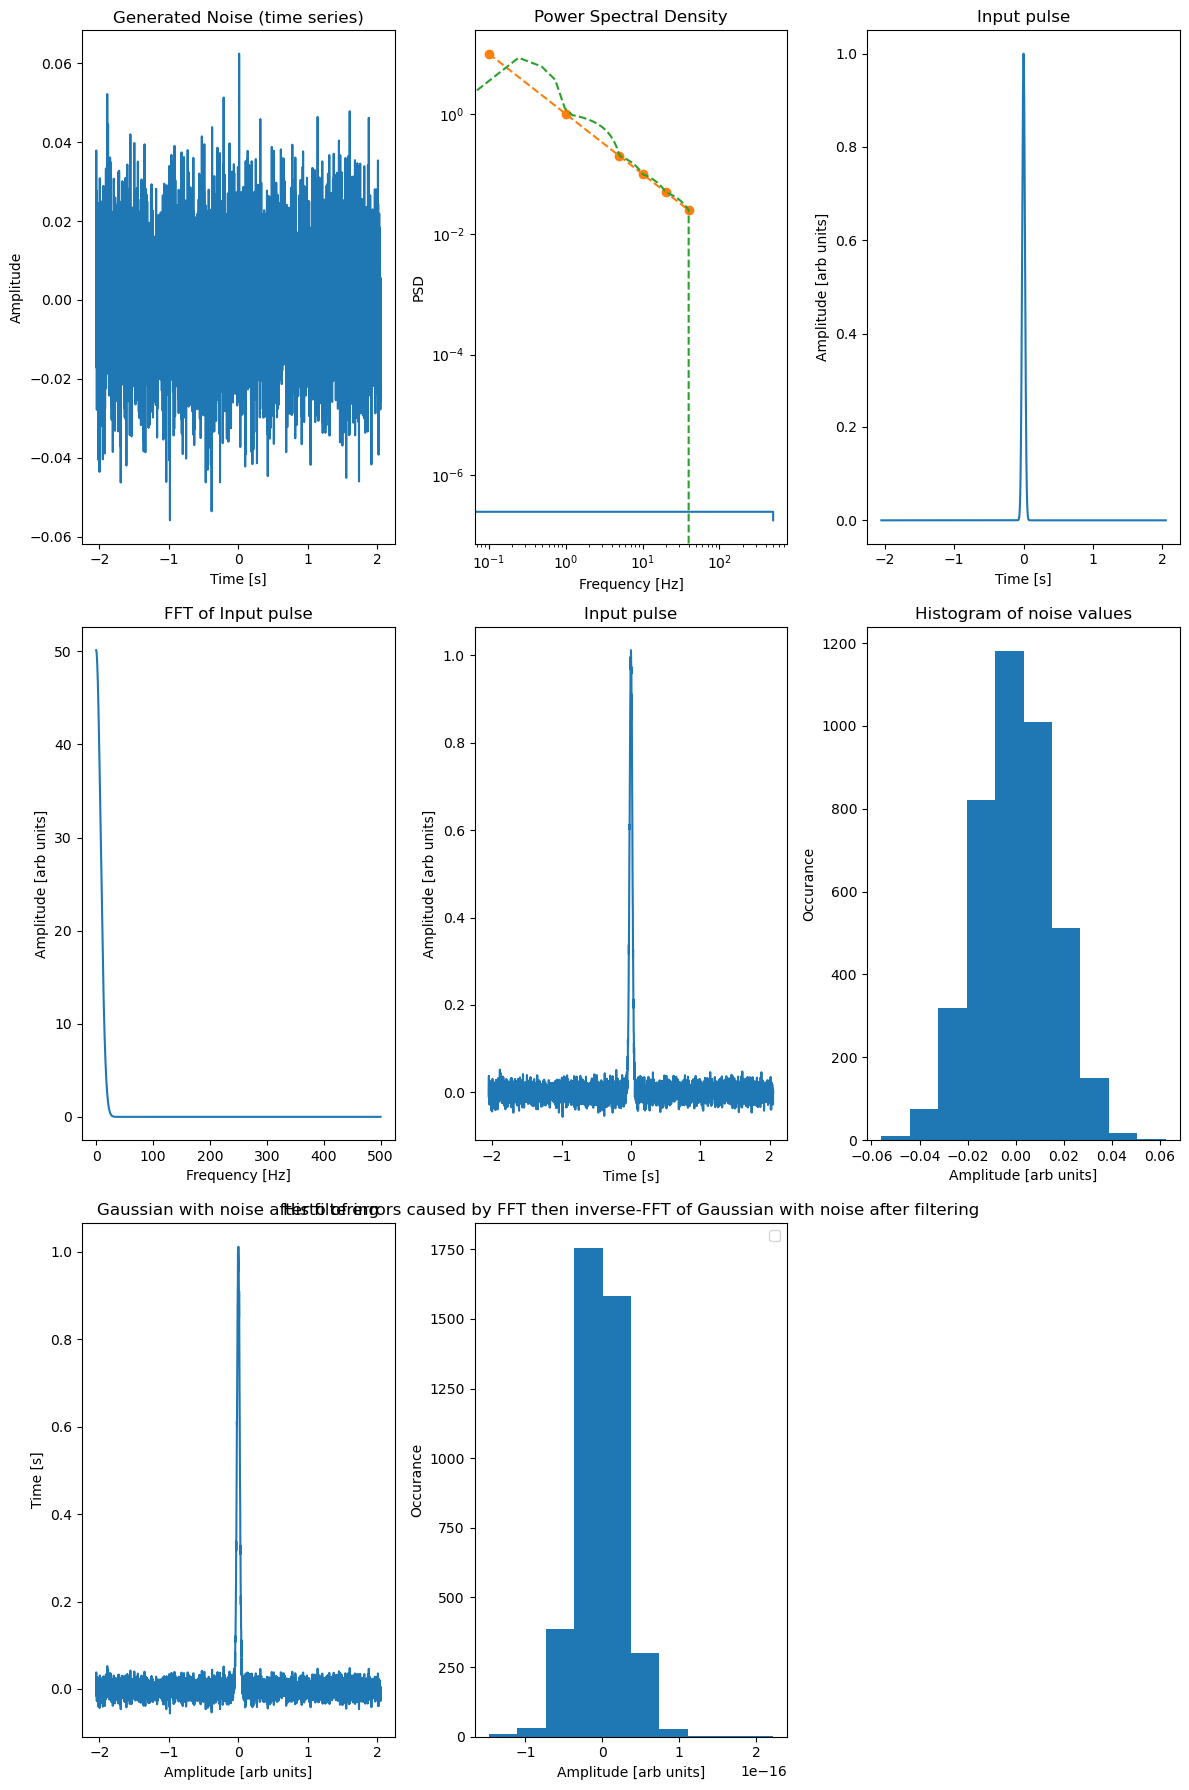

In [68]:
if __name__ == "__main__":
    fs = 1000.0     # Sampling frequency (Hz)
    n_samples = 4096

    # Example "measured" PSD (say, pink noise, but sampled sparsely)
    freqs_measured = np.array([0.1, 1, 5, 10, 20, 40])
    psd_measured = 1.0 / freqs_measured  # just a toy example

    
    # Interpolate onto FFT grid
    freqs_fft, psd_vals = interpolate_psd(freqs_measured, psd_measured, n_samples, fs)

    # Generate noise
    #t, noise_amp, freqs, psd_est = noise_from_psd_array(psd_vals, n_samples, fs)
    t, noise_amp, freqs, psd_est = white_noise_array(n_samples, fs)
    #noise_histo = np.histogram(noise_amp)
    #print(noise_histo)
    
    gaussian_t, gaussian_amp , amplitude_freqs, amplitude_fft = gaussian_time_domain(n_samples=n_samples , fs=fs , centre_pos = 0.5 , time_width=0.02 , peak_height=1.0)

    gaussian_amp_with_noise = gaussian_amp + noise_amp
    print("len(gaussian_amp_with_noise)",len(gaussian_amp_with_noise))
    
    gaussian_with_noise_fft = scipy.fft.rfft(gaussian_amp_with_noise)

    filtered_gaussian_with_noise_fft = gaussian_with_noise_fft

    filtered_gaussian_with_noise_timedomain = scipy.fft.irfft(filtered_gaussian_with_noise_fft).real
    print("len(filtered_gaussian_with_noise_timedomain)",len(filtered_gaussian_with_noise_timedomain))

    gaussian_with_noise_deltas = filtered_gaussian_with_noise_timedomain - gaussian_amp_with_noise
    print("gaussian_with_noise_deltas",gaussian_with_noise_deltas)
    
    print("filtered_gaussian_with_noise_timedomain" , filtered_gaussian_with_noise_timedomain)
    # print("Gaussian" , gaussian_t , gaussian_amp)
    
    # Plot
    plt.figure(figsize=(12,18))
    plt.subplot(3,3,1)
    plt.plot(t, noise_amp)
    plt.title("Generated Noise (time series)")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(3,3,2)
    plt.loglog(freqs, psd_est, label="Estimated PSD")
    plt.loglog(freqs_measured, psd_measured, 'o--', label="Measured PSD (input)")
    plt.loglog(freqs, psd_vals, '--', label="Interpolated PSD")
    plt.title("Power Spectral Density")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD")
    #plt.legend()

    plt.subplot(3,3,3)
    plt.plot(gaussian_t, gaussian_amp)
    plt.title("Input pulse")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [arb units]")
    #plt.legend()

    plt.subplot(3,3,4)
    plt.plot(amplitude_freqs, np.abs(amplitude_fft) )
    plt.title("FFT of Input pulse")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude [arb units]")

    plt.subplot(3,3,5)
    plt.plot(gaussian_t, gaussian_amp_with_noise )
    plt.title("Input pulse")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [arb units]")

    plt.subplot(3,3,6)
    plt.title("Histogram of noise values")
    plt.xlabel("Amplitude [arb units]")
    plt.ylabel("Occurance")
    plt.hist(noise_amp)

    plt.subplot(3,3,7)
    plt.title("Gaussian with noise after filtering")
    plt.xlabel("Amplitude [arb units]")
    plt.ylabel("Time [s]")
    plt.plot(gaussian_t, filtered_gaussian_with_noise_timedomain)

    plt.subplot(3,3,8)
    plt.title("Histo of errors caused by FFT then inverse-FFT of Gaussian with noise after filtering")
    plt.xlabel("Amplitude [arb units]")
    plt.ylabel("Occurance")
    plt.hist(gaussian_with_noise_deltas)
    
    plt.legend()
    plt.tight_layout()
    
    plt.show()

In [39]:
print( freqs_measured)

[ 0.1  1.   5.  10.  20.  40. ]


In [ ]:
print(psd_measured)

In [ ]:
print(freqs_fft, psd_vals)

In [ ]:
print(len(psd_vals))

In [ ]:
print(psd_vals[1000])